# Predictive modeling of stock price

You are provided with one day's worth of market data for two stock tickers (StockA & StockB). The data consists of information from the limit order book and trade information for both stocks merged and ordered chronologically. 
A limit order book consists of two sides: Bid side and Ask side. Bid side represents demand, and the best bid prices represent the highest price at which market participants are willing to buy the given stock. Ask side represents supply, and  best ask price represents the lowest price at which market participants are willing to sell the given stock. A trade transaction occurs when a market participant places an order to buy at or higher than the prevailing Best ask price, or when he/she places an order to sell at or lower than the prevailing Best bid price.

### Description of fields:
`time` is the local timestamp when the updates occurred in microseconds; `symbol` is the stock ticker; `bid`, `ask` are the best bid(ask) prices at the time, `bidSz`,`askSz` are the corresponding total quantities  available at the 'bid' and 'ask' price. When a trade occurs, `trdpx` is the executed price of the transaction, `trdsz` is the executed quantity, `trdsd` is the side of the order in the limit order book being executed(trdsd = 1 implies a trade on the ask side and trdsd = -1 implies a trade on the bid side). 
The `trdpx`, `trdsz`, `trdsd` fields are not populated (default to zero) in rows corresponding to changes in the book; the `bid`, `bidsz`, `ask`, `asksz` are not populated (default to zero) in rows corresponding to trades. 

### Objective:

We would like you to build a quantitative model to make predictions on the future price movement of each individual stock, and understand the relationship between them (if any) based on the information provided. Your end deliverable is provide us with a brief write up of your analysis and code for your final model(s) in MATLAB,R,C++ or Python. Given this is one day worth of data which serves as a toy example, we are not expecting any prediction accuracy/significance of your results, but rather your approaches.

***

# Analysis
#### Edvin Memet (edvinmemet@fas.harvard.edu)

First of all, we see that the two stocks seem quite correlated. Thus, when building a predictive model, we should take into account both stocks to predict price movements of each of them. But first, we will analyze them individually and find out what kind of features and models are useful. We start by reformatting the data, since currently there is separation between updates and trades, which we don't want. For example, if we want to predict future price movements, we don't want to have zeros on the `trdpx` column - we'd rather have the most recent trade price instead. So we will use the ffill (forward fill) method to fill in zeros with the most recent values in that column. 

Next, we should establish what we want to predict, i.e. the time horizon on which we want to forecast changes in price. In principle we could predict prices at this instant, using the difference between the prediction and actual value as the signal. Alternatively, we could predict prices over some future time horizon. Here, for illustration purposes, I choose a time horizon of about five minutes (to be precise, the time horizon is 3000 events, which amounts to about 5 minutes on average). Therefore, to construct the `target` variable, we take the difference between current price and price shifted 3000 events in the future.

Now that we know what our target variable is, we can construct features. As discussed, in reformatting the data, we added columns for the most recent trade price, trade side, and trade size: `last_trdpx`, `last_trdsd`, and `last_trdsz`. For most features, we also want to add moving averages calculated on various window sizes. To do so, I define a function that, for a given feature, adds three columns representing the moving average on windows of size 100, 1000, and 10000 events as well as three additional columns representing the deviation between each moving average and the current value. To understand the relevance of moving averages, consider the feature `last_trdsd`, which can have two values: -1 (buyer jumps to the seller's ask) and 1 (seller falls to buyer's bid). Intuitively, a moving average of `last_trdsd` that is, say, sufficiently negative could signal that the price will go up in the future, since a lot of buyers are willing to make the jump. 

Besides the features we are given, we include features such as: `spread` = ask - bid, `delta_bid` = bid - last_trdpx, `delta_ask` = ask - last_trdpx, ''volume'' `Q` = asksz + bidsz, order book imbalance `I_t` = (bidsz - asksz)/(bidsz + asksz), price momentum `trdpx_momentum2`, trade side momentum `trdsd_momentum2`, detrended price oscillator `dpo2` = past_trdpx2 - trdpx_mva2, trade side multiplied by spread `last_trdsd_scaled` = last_trdsd x spread, trade side multiplied by spread and trade size `last_trdsd_scaled2` = last_trdsd x spread x last_trdsz (intuition: a buyer crossing a larger spread and buying a larger quantity is a stronger signal that prices will go up than a buyer buying a small quantity across a small spread), time interval since last update `delta_time`, and time interval since last trade `time_since_trade`. In principle we can also transorm the time column to a datetime format by adding the time interval in microseconds to the opening time (9:30 am) in order to get additional time features such as hour of the day, minutes, etc (e.g. the market is clearly very volatile near the opening time). If there is any signal in such datetime features, though, it would be revealed by analyzing data over multiple days rather than a single day. 


Next, we test different predictive models: random forest, lightgmb gradient boosting, as well as linear regression. For model validation purposes, we use a simple train-test split (70/30%), though a timeseries k-fold cross-validation would also work. The random forest performs very well with minimal tuning, with a validation root-mean-square error (RMSE) of around 2.2% on stock A and 5% on stock B. To reduce overfitting we set the max_features parameter to sqrt, forcing the decision trees to select from a limited (but always different) number of features at each split. Lightgbm can also perform well but does not outperform random forests out of the box and generally requires too much hyperparameter tuning. Note that in constructing the features I have been careful to avoid look-ahead bias - we cannot use future values of the target variable, which we would not have access to in a real situation. The fact that linear regression perform very badly compared to the ensemble models also suggests that there is no target leakage. 


In total, we have around 100 features. After fitting a predictive model such as a random forest, we might want to get a sense of the most important features in order to guide the feature selection process. Due to time constraints, here we do not implement a process such as forward/backward feature selection, but rather simply remove the least important 20% of features. A simple way to get feature importance in decision-tree models works by shuffling the values of features, one-at-a-time, and observing how much the prediction (of the model trained on the original, unshuffled data) decreases; the more the prediction decreases when you shuffle a feature, the more important that feature is. In addition to the permuted feature importance method, we could use other methods like calculating Shapley Values to get an even better sense of feature importance. In principle, after finding the most important signals, we can continue creating new features based on these signals (e.g. moving averages with additional window sizes, exponential moving averages, etc). We could also easily include higher order polynomial terms or interaction terms between the most important features by using sklearn.preprocessing.PolynomialFeatures, for example. 

After training our model individually on stocks A and B, we combine the data in order to get better predictive power (since there seems to be a good amount of correlation between A and B). Simply combining the two dataframes  already decreases the RMSE for both stocks. Additionally, adding new features such as the difference in scaled prices `last_trdpx_scaled_AB1`, or the ratio of scaled prices `last_trdpx_scaled_AB2`and their corresponding moving averages, further decreases the RMSE. Intuitively, if A and B are highly correlated and the gap between their scaled prices increases, then we might expect the gap will decrease in the future. 


Overall, the model achieves a RMSE of 1% and 3.3% on predicting future changes in price for stocks A and B, respectively (using a 70/30% train/test split). Some possible directions for further improvement are: performing a more rigurous feature selection (e.g. backward selection), trying additional features such as interaction terms or higher order polynomial terms, and optimizing hyperparameters (e.g. using GridSearchCV). In addition, more care would be needed dealing with time; at the moment our measure of time in computing features involving moving averages, shifts, or momentum is simply event-based. However, events (updates in the limit order book and trades) do not happen at regular intervals, which induces some noise into our features. Since our prediction horizon is somewhat large (3000 events or about 5 minutes), the noise should average out to a good extent.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

forecast_period = 3000
window_s, window_m, window_l = 100, 1000, 10000


def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(16,10), legend=False)

def print_scores(reg, x_tr, y_tr, x_val, y_val, model):
    r2 = reg.score(x_tr, y_tr)
    rmspe_train = np.sqrt(mean_squared_error(reg.predict(x_tr), y_tr.values))
    rmspe_val = np.sqrt(mean_squared_error(reg.predict(x_val), y_val.values))
    print(model + ': R^2 = ' + str(round(r2,3)) + ', ' + 'RMSE = ' + 
          str(round(rmspe_train,3)) + ', ' + 'RMSE validation = ' + 
          str(round(rmspe_val,3)))

def add_mva(df, feature_list):
    for feature_name in feature_list:
        if 'last_' in feature_name:
            new_feature_name=feature_name.replace('last_', '')  
        else:
            new_feature_name=feature_name
        df[new_feature_name+'_mva1'] = df[feature_name].rolling(window=window_s).mean()
        df[new_feature_name+'_mva2'] = df[feature_name].rolling(window=window_m).mean()
        df[new_feature_name+'_mva3'] = df[feature_name].rolling(window=window_l).mean()
        df['delta_'+new_feature_name+'_mva1'] = df[new_feature_name+'_mva1'] - df[feature_name]
        df['delta_'+new_feature_name+'_mva2'] = df[new_feature_name+'_mva2'] - df[feature_name]
        df['delta_'+new_feature_name+'_mva3'] = df[new_feature_name+'_mva3'] - df[feature_name]

def display_all(df):
    with pd.option_context("display.max_rows", 50, "display.max_columns", 500): 
        display(df)
        
def plot_AB(df1, df2):
    df1_trd = df1[(df1.ask == 0) & (df1.asksz == 0) & (df1.bid == 0) & (df1.bidsz == 0)]
    df2_trd = df2[(df2.ask == 0) & (df2.asksz == 0) & (df2.bid == 0) & (df2.bidsz == 0)]
    df1_trd.loc[:, 'trdpx'] = df1_trd['trdpx']/max(df1_trd['trdpx'])
    df2_trd.loc[:, 'trdpx'] = df2_trd['trdpx']/max(df2_trd['trdpx'])
    fig, ax = plt.subplots(figsize= (9, 4.6))
    sns.lineplot(x = df1_trd['time'], y = df1_trd['trdpx'], color = 'navy', linewidth = 3, label= "stock A")
    sns.lineplot(x = df2_trd['time'], y = df2_trd['trdpx'], color = 'crimson', linewidth = 3, label= "stock B")
    ax.set_xlabel("Time",fontsize=20); ax.set_ylabel("Trade price",fontsize=20) 
    fig.suptitle('Scaled trade prices of stocks A and B', fontsize=22);ax.tick_params(labelsize=13); ax.legend(fontsize='17');

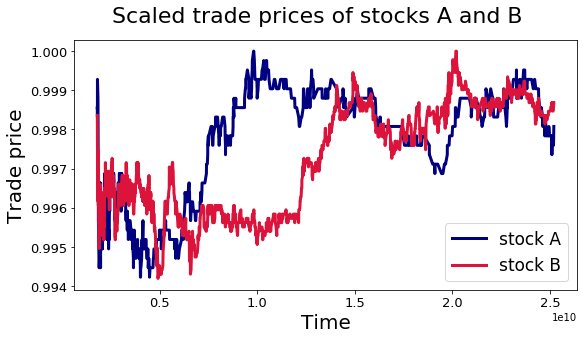

In [22]:
url = 'https://raw.githubusercontent.com/edvinmemet/projects/master/data/price_forecasting/data2.csv?token=AF52KYML4FDCHGE7R735LNC5VAR7U'
df = pd.read_csv(url)
dfA = df[df.symbol == 'STOCKA'].drop(columns = 'symbol')
dfB = df[df.symbol == 'STOCKB'].drop(columns = 'symbol')

plot_AB(dfA, dfB)

## Reformatting and feature generation

In [23]:
dfA.loc[dfA.trdpx==0, ['trdsd', 'trdsz', 'trdpx']] = np.nan #replace zeros with nan
dfA = dfA.ffill() #forward fill the nans
dfA[['trdsd', 'trdsz', 'trdpx']] = dfA[['trdsd', 'trdsz', 'trdpx']].shift(1)
dfA = dfA.rename(columns = {'trdsd': 'last_trdsd', 'trdsz': 'last_trdsz', 'trdpx': 'last_trdpx'})
dfA['time_last_trade'] = dfA.loc[dfA.bid == 0, 'time']
dfA['time_last_trade'] = dfA['time_last_trade'].shift(2).ffill()
dfA['time_since_trade'] = dfA['time'] - dfA['time_last_trade'] #time interval since last trade
dfA = dfA.drop(columns = 'time_last_trade')
dfA = dfA.loc[dfA.bid != 0, :] 
dfA['delta_time'] = dfA[['time']].diff() #time interval since last update

dfA['spread'] = dfA['ask'] - dfA['bid'] #spread
dfA['spread2'] = (dfA['ask'] - dfA['bid'])/(dfA['ask'] + dfA['bid'])
dfA['Q'] = dfA['bidsz'] + dfA['asksz'] #volume
dfA['I_t'] = (dfA['bidsz'] - dfA['asksz'])/(dfA['bidsz'] + dfA['asksz']) #order book imbalance
dfA['last_trdsd_scaled'] = dfA['last_trdsd'] * dfA['spread']
dfA['last_trdsd_scaled2'] = dfA['last_trdsd'] * dfA['spread'] * dfA['last_trdsz']
dfA['delta_bid'] = dfA['bid'] - dfA['last_trdpx']
dfA['delta_ask'] = dfA['ask'] - dfA['last_trdpx']

#add moving averages
add_mva(dfA, ['last_trdsd_scaled', 'last_trdsd_scaled2', 'last_trdpx', 'last_trdsd', 
        'last_trdsz', 'spread', 'Q', 'ask', 'bid', 'delta_time', 'time_since_trade', 
        'delta_bid', 'delta_ask'])

dfA['past_trdpx2'] = dfA['last_trdpx'].shift(window_s//2)
dfA['past_trdpx3'] = dfA['last_trdpx'].shift(window_m//2)
dfA['dpo2'] = dfA['past_trdpx2'] - dfA['trdpx_mva2']
dfA['dpo3'] = dfA['past_trdpx3'] - dfA['trdpx_mva3']
dfA['trdpx_momentum2'] = dfA['delta_trdpx_mva2']/(dfA['time'] - dfA['time'].shift(window_m))
dfA['trdpx_momentum3'] = dfA['delta_trdpx_mva3']/(dfA['time'] - dfA['time'].shift(window_l))
dfA['trdsd_momentum2'] = dfA['delta_trdsd_mva2']/(dfA['time'] - dfA['time'].shift(window_m))
dfA['trdsd_momentum3'] = dfA['delta_trdsd_mva3']/(dfA['time'] - dfA['time'].shift(window_l))


dfA['target'] = dfA['last_trdpx'].shift(-forecast_period).rolling(window=window_m).mean() - dfA['last_trdpx']
dfA = dfA.loc[dfA.notna().min(axis=1),:] #remove nan values (arising from moving averages, etc.)
display_all(dfA)

,time,bid,bidsz,ask,asksz,last_trdsz,last_trdsd,last_trdpx,time_since_trade,delta_time,spread,spread2,Q,I_t,last_trdsd_scaled,last_trdsd_scaled2,delta_bid,delta_ask,trdsd_scaled_mva1,trdsd_scaled_mva2,trdsd_scaled_mva3,delta_trdsd_scaled_mva1,delta_trdsd_scaled_mva2,delta_trdsd_scaled_mva3,trdsd_scaled2_mva1,trdsd_scaled2_mva2,trdsd_scaled2_mva3,delta_trdsd_scaled2_mva1,delta_trdsd_scaled2_mva2,delta_trdsd_scaled2_mva3,trdpx_mva1,trdpx_mva2,trdpx_mva3,delta_trdpx_mva1,delta_trdpx_mva2,delta_trdpx_mva3,trdsd_mva1,trdsd_mva2,trdsd_mva3,delta_trdsd_mva1,delta_trdsd_mva2,delta_trdsd_mva3,trdsz_mva1,trdsz_mva2,trdsz_mva3,delta_trdsz_mva1,delta_trdsz_mva2,delta_trdsz_mva3,spread_mva1,spread_mva2,spread_mva3,delta_spread_mva1,delta_spread_mva2,delta_spread_mva3,Q_mva1,Q_mva2,Q_mva3,delta_Q_mva1,delta_Q_mva2,delta_Q_mva3,ask_mva1,ask_mva2,ask_mva3,delta_ask_mva1,delta_ask_mva2,delta_ask_mva3,bid_mva1,bid_mva2,bid_mva3,delta_bid_mva1,delta_bid_mva2,delta_bid_mva3,delta_time_mva1,delta_time_mva2,delta_time_mva3,delta_delta_time_mva1,delta_delta_time_mva2,delta_delta_time_mva3,time_since_trade_mva1,time_since_trade_mva2,time_since_trade_mva3,delta_time_since_trade_mva1,delta_time_since_trade_mva2,delta_time_since_trade_mva3,delta_delta_bid_mva1,delta_delta_bid_mva2,delta_delta_bid_mva3,delta_delta_ask_mva1,delta_delta_ask_mva2,delta_delta_ask_mva3,past_trdpx2,past_trdpx3,dpo2,dpo3,trdpx_momentum2,trdpx_momentum3,trdsd_momentum2,trdsd_momentum3,target
15325,2402664082,4138,15,4140,40,3.0,-1.0,4139.0,3108311.0,22.0,2,0.000242,55,-0.454545,-2.0,-6.0,-1.0,1.0,-2.0,-0.908,-0.5661,0.0,1.092,1.4339,-6.0,-2.328,1.1488,0.0,3.672,7.1488,4139.0,4138.036,4141.3837,0.0,-0.964,2.3837,-1.0,-0.534,0.0086,0.0,0.466,1.0086,3.0,1.933,2.0228,0.0,-1.067,-0.9772,2.0,1.686,4.5275,0.0,-0.314,2.5275,42.76,49.482,27.9858,-12.24,-5.518,-27.0142,4140.0,4138.891,4143.1059,1.0,0.855,1.7222,4138.0,4137.205,4138.5784,-1.0,-0.831,-2.8053,12.13,20051.493,59693.6066,-9.87,20029.493,59671.6066,3107693.42,574082.480,2.911075e+06,-617.58,-2.534229e+06,-1.972361e+05,0.0,0.169,-1.8053,0.0,-0.145,0.7222,4139.0,4138.0,0.964,-3.3837,-4.807622e-08,3.993225e-09,2.324016e-08,1.689628e-09,4.237
15326,2402664095,4138,15,4140,38,3.0,-1.0,4139.0,3108324.0,13.0,2,0.000242,53,-0.433962,-2.0,-6.0,-1.0,1.0,-2.0,-0.912,-0.5671,0.0,1.088,1.4329,-6.0,-2.336,1.1474,0.0,3.664,7.1474,4139.0,4138.037,4141.3824,0.0,-0.963,2.3824,-1.0,-0.536,0.0084,0.0,0.464,1.0084,3.0,1.935,2.0230,0.0,-1.065,-0.9770,2.0,1.686,4.5269,0.0,-0.314,2.5269,42.93,49.489,27.9894,-10.07,-3.511,-25.0106,4140.0,4138.892,4143.1046,1.0,0.855,1.7222,4138.0,4137.206,4138.5777,-1.0,-0.831,-2.8047,12.14,20051.499,59684.0158,-0.86,20038.499,59671.0158,3107705.56,577190.597,2.911376e+06,-618.44,-2.531133e+06,-1.969479e+05,0.0,0.169,-1.8047,0.0,-0.145,0.7222,4139.0,4138.0,0.963,-3.3824,-4.802633e-08,3.991689e-09,2.314041e-08,1.689565e-09,4.237
15327,2402664098,4138,15,4140,40,3.0,-1.0,4139.0,3108327.0,3.0,2,0.000242,55,-0.454545,-2.0,-6.0,-1.0,1.0,-2.0,-0.916,-0.5688,0.0,1.084,1.4312,-6.0,-2.344,1.1453,0.0,3.656,7.1453,4139.0,4138.038,4141.3811,0.0,-0.962,2.3811,-1.0,-0.538,0.0082,0.0,0.462,1.0082,3.0,1.937,2.0232,0.0,-1.063,-0.9768,2.0,1.686,4.5256,0.0,-0.314,2.5256,43.10,49.499,27.9918,-11.90,-5.501,-27.0082,4140.0,4138.893,4143.1033,1.0,0.855,1.7222,4138.0,4137.207,4138.5777,-1.0,-0.831,-2.8034,12.14,20051.502,59650.6061,9.14,20048.502,59647.6061,3107717.70,580298.717,2.911644e+06,-609.30,-2.528028e+06,-1.966831e+05,0.0,0.169,-1.8034,0.0,-0.145,0.7222,4139.0,4138.0,0.962,-3.3811,-4.797646e-08,3.991745e-09,2.304067e-08,1.690176e-09,4.237
15328,2402664119,4138,15,4140,38,3.0,-1.0,4139.0,3108348.0,21.0,2,0.000242,53,-0.433962,-2.0,-6.0,-1.0,1.0,-2.0,-0.920,-0.5705,0.0,1.080,1.4295,-6.0,-2.352,1.1432,0.0,3.648,7.1432,4139.0,4138.039,4141.3798,0.0,-0.961,2.3798,-1.0,-0.540,0.0080,0.0,0.460,1.0080,3.0,1.939,2.0234,0.0,-1.061,-0.9766,2.0,1.686,4.5243,0.0,-0.314,2.5243,43.27,49.506,27.9940,-9.73,-3.494,-25.0060,4140.0,4138.894,4143.1020,1.

After creating new features, the dataframe has 98 features. Below, we visualize correlations, first between all pairs of features, and next beween all features and the target variable. 

## Exploratory data analysis

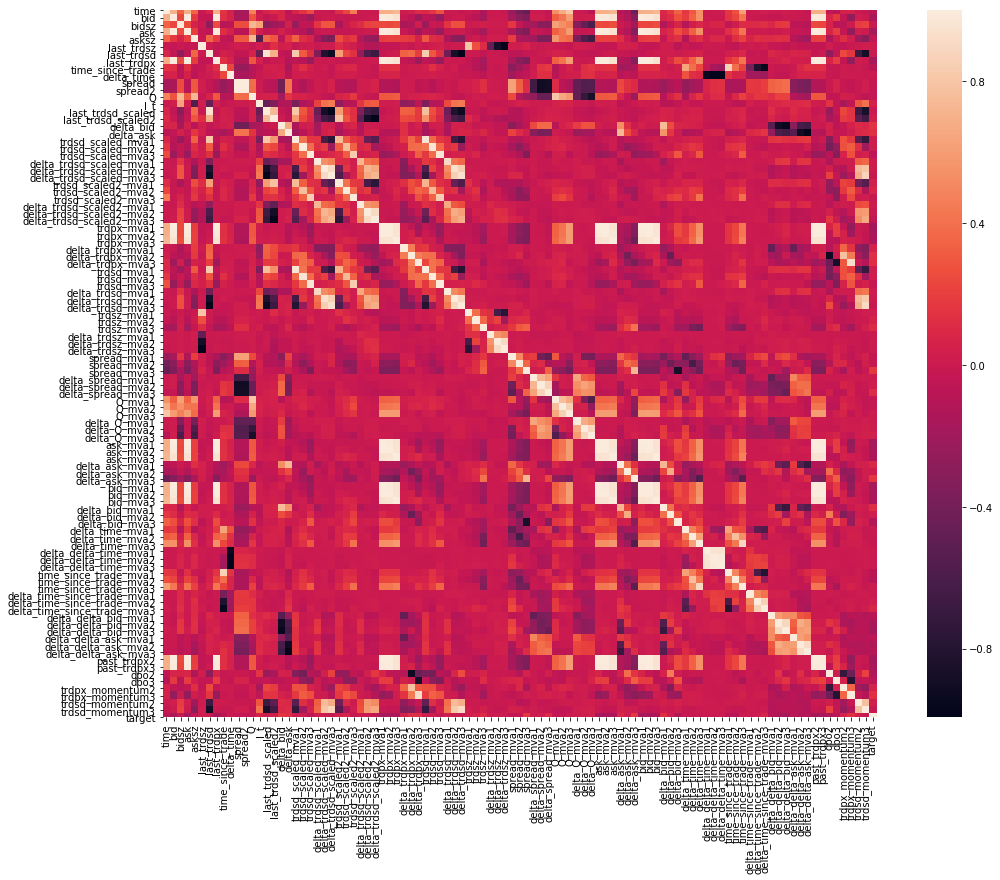

In [24]:
corrmat = dfA.corr()
plt.subplots(figsize=(18,13))
sns.heatmap(corrmat, square=True, xticklabels=True, yticklabels=True)

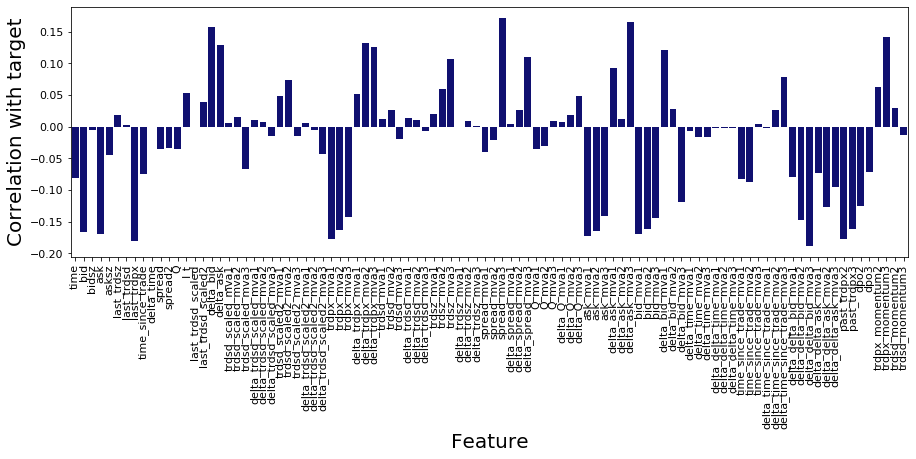

In [25]:
cor = []
for col in dfA.drop(columns='target').columns:
    cor.append(dfA[['target', col]].corr().iloc[0,1])
target_corr = pd.DataFrame(list(zip(cor, dfA.drop(columns='target').columns)), columns =['correlation', 'feature'])

fig, ax = plt.subplots(figsize= (15, 4.6))
g = sns.barplot(x = target_corr.feature, y = target_corr.correlation, color = 'navy')
g.set_xticklabels(target_corr.feature, rotation=90);
ax.set_xlabel("Feature",fontsize=20); ax.set_ylabel("Correlation with target",fontsize=20) 
ax.tick_params(labelsize=11);

We can also examine boxplots, showing the distribution of the target variable for different values of a given feature. Since most features are continuous, we would have to bin them into a smaller number of categories (e.g. by rounding). 

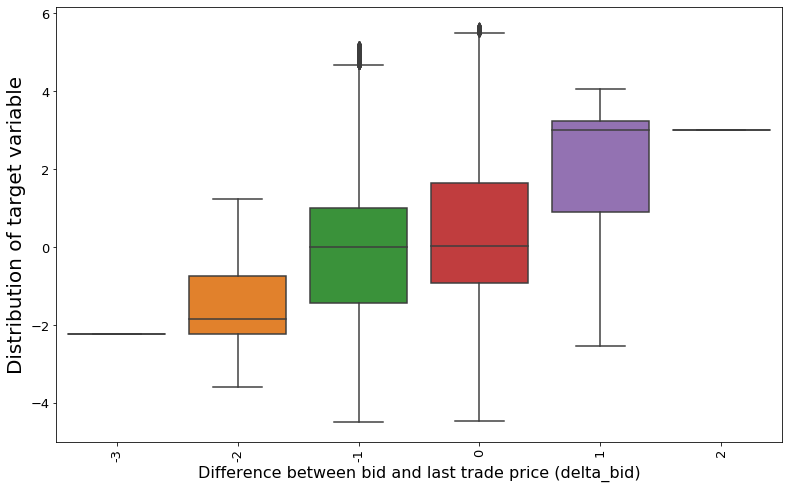

In [26]:
f, ax = plt.subplots(figsize=(13, 8))
g = sns.boxplot(y=dfA['target'] , x=dfA['delta_bid'].apply(np.int64))
plt.xticks(rotation=90); 
ax.set_xlabel("Difference between bid and last trade price (delta_bid)",fontsize=16); ax.set_ylabel("Distribution of target variable",fontsize=20) 
ax.tick_params(labelsize=13);

## Model selection

In [27]:
x = dfA.drop(columns='target')
y = dfA['target']
x, x_test, y, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=7, max_features='sqrt', n_jobs=-1)
rf.fit(x, y)
print_scores(rf, x, y, x_test, y_test, 'Random Forest')

reg = linear_model.LinearRegression()
reg.fit(x, y)
print_scores(reg, x, y, x_test, y_test, 'Linear Regression')

Random Forest: R^2 = 1.0, RMSE = 0.015, RMSE validation = 0.022
Linear Regression: R^2 = 0.29, RMSE = 1.506, RMSE validation = 1.506


In [28]:
gbm = lgb.LGBMRegressor(num_leaves = 8, learning_rate=0.5, n_estimators=100, num_boost_round=500)
gbm.fit(x, y, eval_set=[(x_test, y_test)], verbose = False, eval_metric='rmse');
print_scores(gbm, x, y, x_test, y_test, 'Lgbm Gradient Boosting')

Lgbm Gradient Boosting: R^2 = 0.998, RMSE = 0.089, RMSE validation = 0.095


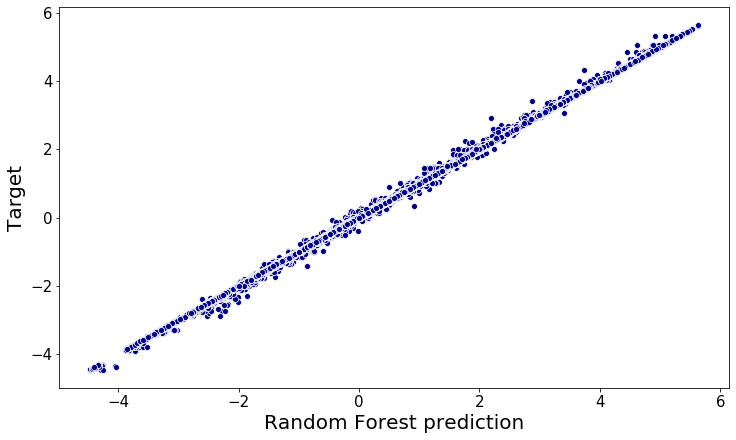

In [29]:
fig, ax = plt.subplots(figsize= (12, 7))
g = sns.scatterplot(x = rf.predict(x_test), y = y_test, color = 'navy')
ax.set_xlabel("Random Forest prediction",fontsize=20); ax.set_ylabel("Target",fontsize=20) 
ax.tick_params(labelsize=15);

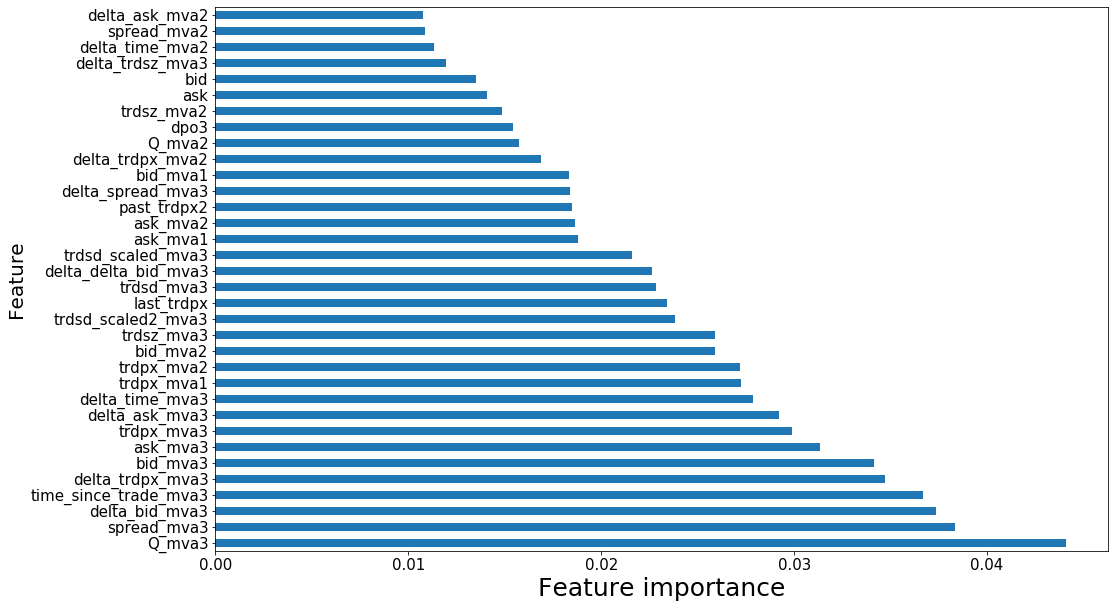

In [30]:
fi = rf_feat_importance(rf, x)
g = plot_fi(fi[1:35])
g.set_xlabel("Feature importance",fontsize=25); g.set_ylabel("Feature",fontsize=20);
g.tick_params(labelsize=15);
dfA = dfA.drop(fi[-20:].cols, axis=1)

In [31]:
x = dfA.drop(columns='target')
y = dfA['target']
x, x_test, y, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=7, max_features='sqrt', n_jobs=-1)
rf.fit(x, y)
print_scores(rf, x, y, x_test, y_test, 'RF')

RF: R^2 = 1.0, RMSE = 0.014, RMSE validation = 0.02


Dropping the 20 least important features improves the RMSE on the test set from 2.2% to 2%.

## Repeating analysis for Stock B

In [32]:
dfB.loc[dfB.trdpx==0, ['trdsd', 'trdsz', 'trdpx']] = np.nan #replace zeros with nan
dfB = dfB.ffill() #forward fill the nans
dfB[['trdsd', 'trdsz', 'trdpx']] = dfB[['trdsd', 'trdsz', 'trdpx']].shift(1)
dfB = dfB.rename(columns = {'trdsd': 'last_trdsd', 'trdsz': 'last_trdsz', 'trdpx': 'last_trdpx'})
dfB['time_last_trade'] = dfB.loc[dfB.bid == 0, 'time']
dfB['time_last_trade'] = dfB['time_last_trade'].shift(2).ffill()
dfB['time_since_trade'] = dfB['time'] - dfB['time_last_trade'] #time interval since last trade
dfB = dfB.drop(columns = 'time_last_trade')
dfB = dfB.loc[dfB.bid != 0, :] 
dfB['delta_time'] = dfB[['time']].diff() #time interval since last update

dfB['spread'] = dfB['ask'] - dfB['bid'] #spread
dfB['spread2'] = (dfB['ask'] - dfB['bid'])/(dfB['ask'] + dfB['bid'])
dfB['Q'] = dfB['bidsz'] + dfB['asksz'] #volume
dfB['I_t'] = (dfB['bidsz'] - dfB['asksz'])/(dfB['bidsz'] + dfB['asksz']) #order book imbalance
dfB['last_trdsd_scaled'] = dfB['last_trdsd'] * dfB['spread']
dfB['last_trdsd_scaled2'] = dfB['last_trdsd'] * dfB['spread'] * dfB['last_trdsz']
dfB['delta_bid'] = dfB['bid'] - dfB['last_trdpx']
dfB['delta_ask'] = dfB['ask'] - dfB['last_trdpx']

#add moving averages
add_mva(dfB, ['last_trdsd_scaled', 'last_trdsd_scaled2', 'last_trdpx', 'last_trdsd', 
        'last_trdsz', 'spread', 'Q', 'ask', 'bid', 'delta_time', 'time_since_trade', 
        'delta_bid', 'delta_ask'])

dfB['past_trdpx2'] = dfB['last_trdpx'].shift(window_s//2)
dfB['past_trdpx3'] = dfB['last_trdpx'].shift(window_m//2)
dfB['dpo2'] = dfB['past_trdpx2'] - dfB['trdpx_mva2']
dfB['dpo3'] = dfB['past_trdpx3'] - dfB['trdpx_mva3']
dfB['trdpx_momentum2'] = dfB['delta_trdpx_mva2']/(dfB['time'] - dfB['time'].shift(window_m))
dfB['trdpx_momentum3'] = dfB['delta_trdpx_mva3']/(dfB['time'] - dfB['time'].shift(window_l))
dfB['trdsd_momentum2'] = dfB['delta_trdsd_mva2']/(dfB['time'] - dfB['time'].shift(window_m))
dfB['trdsd_momentum3'] = dfB['delta_trdsd_mva3']/(dfB['time'] - dfB['time'].shift(window_l))


dfB['target'] = dfB['last_trdpx'].shift(-forecast_period).rolling(window=window_m).mean() - dfB['last_trdpx']
dfB = dfB.loc[dfB.notna().min(axis=1),:] #remove nan values (arising from moving averages, etc.)
display_all(dfB)

,time,bid,bidsz,ask,asksz,last_trdsz,last_trdsd,last_trdpx,time_since_trade,delta_time,spread,spread2,Q,I_t,last_trdsd_scaled,last_trdsd_scaled2,delta_bid,delta_ask,trdsd_scaled_mva1,trdsd_scaled_mva2,trdsd_scaled_mva3,delta_trdsd_scaled_mva1,delta_trdsd_scaled_mva2,delta_trdsd_scaled_mva3,trdsd_scaled2_mva1,trdsd_scaled2_mva2,trdsd_scaled2_mva3,delta_trdsd_scaled2_mva1,delta_trdsd_scaled2_mva2,delta_trdsd_scaled2_mva3,trdpx_mva1,trdpx_mva2,trdpx_mva3,delta_trdpx_mva1,delta_trdpx_mva2,delta_trdpx_mva3,trdsd_mva1,trdsd_mva2,trdsd_mva3,delta_trdsd_mva1,delta_trdsd_mva2,delta_trdsd_mva3,trdsz_mva1,trdsz_mva2,trdsz_mva3,delta_trdsz_mva1,delta_trdsz_mva2,delta_trdsz_mva3,spread_mva1,spread_mva2,spread_mva3,delta_spread_mva1,delta_spread_mva2,delta_spread_mva3,Q_mva1,Q_mva2,Q_mva3,delta_Q_mva1,delta_Q_mva2,delta_Q_mva3,ask_mva1,ask_mva2,ask_mva3,delta_ask_mva1,delta_ask_mva2,delta_ask_mva3,bid_mva1,bid_mva2,bid_mva3,delta_bid_mva1,delta_bid_mva2,delta_bid_mva3,delta_time_mva1,delta_time_mva2,delta_time_mva3,delta_delta_time_mva1,delta_delta_time_mva2,delta_delta_time_mva3,time_since_trade_mva1,time_since_trade_mva2,time_since_trade_mva3,delta_time_since_trade_mva1,delta_time_since_trade_mva2,delta_time_since_trade_mva3,delta_delta_bid_mva1,delta_delta_bid_mva2,delta_delta_bid_mva3,delta_delta_ask_mva1,delta_delta_ask_mva2,delta_delta_ask_mva3,past_trdpx2,past_trdpx3,dpo2,dpo3,trdpx_momentum2,trdpx_momentum3,trdsd_momentum2,trdsd_momentum3,target
32382,2856910580,9091,1,9094,2,1.0,-1.0,9092.0,22396862.0,310950.0,3,0.000165,3,-0.333333,-3.0,-3.0,-1.0,2.0,-3.30,0.734,0.4894,-0.30,3.734,3.4894,-3.30,0.922,1.0926,-0.30,3.922,4.0926,9092.0,9091.142,9097.2434,0.0,-0.858,5.2434,-1.0,0.304,0.0420,0.0,1.304,1.0420,1.0,1.064,1.3189,0.0,0.064,0.3189,3.30,2.744,4.4308,0.30,-0.256,1.4308,8.27,5.232,5.4391,5.27,2.232,2.4391,9093.55,9092.898,9099.2357,1.55,1.756,1.9923,9090.25,9090.154,9094.8049,-1.75,-0.988,-2.4385,130395.21,113549.590,104921.6460,-180554.79,-197400.410,-2.060284e+05,15465385.61,7316835.194,4.084690e+06,-6931476.39,-1.508003e+07,-1.831217e+07,-0.75,0.012,-1.4385,-0.45,-0.244,-0.0077,9092.0,9089.0,0.858,-8.2434,-7.556170e-09,4.997444e-09,1.148397e-08,9.931220e-10,7.677
32383,2856910674,9091,7,9094,2,1.0,-1.0,9092.0,22396956.0,94.0,3,0.000165,9,0.555556,-3.0,-3.0,-1.0,2.0,-3.29,0.728,0.4902,-0.29,3.728,3.4902,-3.29,0.916,1.0934,-0.29,3.916,4.0934,9092.0,9091.143,9097.2410,0.0,-0.857,5.2410,-1.0,0.302,0.0420,0.0,1.302,1.0420,1.0,1.064,1.3189,0.0,0.064,0.3189,3.29,2.744,4.4300,0.29,-0.256,1.4300,8.30,5.237,5.4396,-0.70,-3.763,-3.5604,9093.55,9092.900,9099.2335,1.55,1.757,1.9925,9090.26,9090.156,9094.8035,-1.74,-0.987,-2.4375,130368.43,113549.238,104921.6536,130274.43,113455.238,1.048277e+05,15595754.04,7335453.055,4.086929e+06,-6801201.96,-1.506150e+07,-1.831003e+07,-0.74,0.013,-1.4375,-0.45,-0.243,-0.0075,9092.0,9089.0,0.857,-8.2410,-7.547387e-09,4.995156e-09,1.146639e-08,9.931220e-10,7.680
32384,2856910738,9091,8,9094,2,1.0,-1.0,9092.0,22397020.0,64.0,3,0.000165,10,0.600000,-3.0,-3.0,-1.0,2.0,-3.28,0.722,0.4910,-0.28,3.722,3.4910,-3.28,0.910,1.0942,-0.28,3.910,4.0942,9092.0,9091.144,9097.2386,0.0,-0.856,5.2386,-1.0,0.300,0.0420,0.0,1.300,1.0420,1.0,1.064,1.3189,0.0,0.064,0.3189,3.28,2.744,4.4292,0.28,-0.256,1.4292,8.35,5.243,5.4402,-1.65,-4.757,-4.5598,9093.55,9092.902,9099.2313,1.55,1.758,1.9927,9090.27,9090.158,9094.8021,-1.73,-0.986,-2.4365,130368.71,113503.690,104921.6050,130304.71,113439.690,1.048576e+05,15726122.75,7354025.368,4.089169e+06,-6670897.25,-1.504299e+07,-1.830785e+07,-0.73,0.014,-1.4365,-0.45,-0.242,-0.0073,9092.0,9089.0,0.856,-8.2386,-7.541605e-09,4.992871e-09,1.145337e-08,9.931224e-10,7.683
32385,2856910793,9091,8,9094,1,1.0,-1.0,9092.0,22397075.0,55.0,3,0.000165,9,0.777778,-3.0,-3.0,-1.0,2.0,-3.27,0.716,0.4918,-0.27,3.716,3.4918,-3.27,0.904,1.0950,-0.27,3.904,4.0950,9092.0,9091.145,9097.2362,0.0,-0.855,5.2362,-1.0,0.298,0.0420,0.0,1.298,1.0420,1.0,1.064,1.3189,0.0,0.064,0.3189,3.27,2.744,4.4284,0.27,-0.256,1.428

In [33]:
x = dfB.drop(columns='target')
y = dfB['target']
x, x_test, y, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=7, max_features='sqrt', n_jobs=-1)
rf.fit(x, y)
print_scores(rf, x, y, x_test, y_test, 'RF')

RF: R^2 = 1.0, RMSE = 0.034, RMSE validation = 0.05


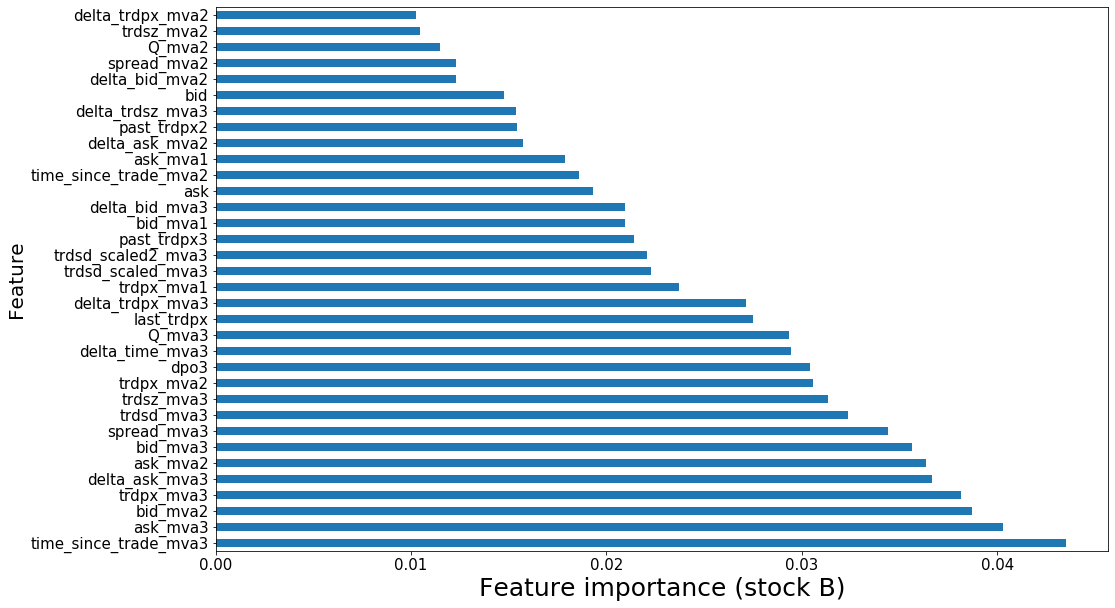

In [34]:
fi = rf_feat_importance(rf, x)
g = plot_fi(fi[1:35])
g.set_xlabel("Feature importance (stock B)",fontsize=25); g.set_ylabel("Feature",fontsize=20);
g.tick_params(labelsize=15);
dfB = dfB.drop(fi[-20:].cols, axis=1)

In [35]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=7, max_features='sqrt', n_jobs=-1)
rf.fit(x, y)
print_scores(rf, x, y, x_test, y_test, 'RF')

RF: R^2 = 1.0, RMSE = 0.033, RMSE validation = 0.05


After removing the least important 20 features the RMSE improves slightly. 

## Combining data from A and B to improve predictions

In [36]:
dfA.columns = [str(col) + '_A' for col in dfA.columns]
dfA = dfA.rename(columns = {'time_A':'time'})
dfB.columns = [str(col) + '_B' for col in dfB.columns]
dfB = dfB.rename(columns = {'time_B':'time'})
df_AB = pd.merge(dfA, dfB, how='outer', on='time')
df_AB = df_AB.ffill()
df_AB = df_AB.loc[df_AB.notna().min(axis=1),:]
df_AB

,time,bid_A,bidsz_A,ask_A,asksz_A,last_trdsz_A,last_trdpx_A,time_since_trade_A,spread2_A,Q_A,...,delta_delta_bid_mva2_B,delta_delta_bid_mva3_B,delta_delta_ask_mva1_B,delta_delta_ask_mva2_B,delta_delta_ask_mva3_B,past_trdpx2_B,past_trdpx3_B,dpo2_B,dpo3_B,target_B
11373,2873732786,4144.0,14.0,4145.0,8.0,2.0,4144.0,2446649.0,0.000121,22.0,...,-1.208,-2.3325,-0.94,-1.440,-1.1185,9095.0,9091.0,3.306,-5.9970,5.356
11374,2873740239,4144.0,16.0,4145.0,8.0,2.0,4144.0,2454102.0,0.000121,24.0,...,-1.208,-2.3325,-0.94,-1.440,-1.1185,9095.0,9091.0,3.306,-5.9970,5.356
11375,2873800959,4144.0,16.0,4145.0,8.0,2.0,4144.0,2514822.0,0.000121,24.0,...,-1.208,-2.3325,-0.94,-1.440,-1.1185,9095.0,9091.0,3.306,-5.9970,5.356
11376,2873888959,4144.0,18.0,4145.0,8.0,2.0,4144.0,2602822.0,0.000121,26.0,...,-1.208,-2.3325,-0.94,-1.440,-1.1185,9095.0,9091.0,3.306,-5.9970,5.356
11377,2873955460,4144.0,18.0,4145.0,7.0,2.0,4144.0,2669323.0,0.000121,25.0,...,-1.208,-2.3325,-0.94,-1.440,-1.1185,9095.0,9091.0,3.306,-5.9970,5.356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423619,24876800087,4149.0,97.0,4150.0,75.0,1.0,4149.0,33940816.0,0.000120,172.0,...,0.475,0.4738,0.00,0.511,0.5778,9116.0,9116.0,0.520,-1.3330,2.092
423620,24878074167,4149.0,97.0,4150.0,75.0,1.0,4149.0,33940816.0,0.000120,172.0,...,0.475,0.4737,0.00,0.511,0.5777,9116.0,9116.0,0.518,-1.3325,2.092
423621,24878074243,4149.0,97.0,4150.0,75.0,1.0,4149.0,33940816.0,0.000120,172.0,...,0.475,0.4736,0.00,0.511,0.5776,9116.0,9116.0,0.516,-1.3320,2.092
423622,24878074262,4149.0,97.0,4150.0,75.0,1.0,4149.0,33940816.0,0.000120,172.0,...,0.475,0.4736,0.00,0.511,0.5775,9116.0,9116.0,0.514,-1.3315,2.092


The joined dataframe has 155 features. We use these to predict each of the target variables, `target_A` and `target_B`, in turn. Intuitively, if the two stocks are correlated, using data from the other one can help improve the prediction. First, let's predict `target_A`:

In [37]:
x_A = df_AB.drop(columns=['target_A', 'target_B']) #drop both target variables
y_A = df_AB['target_A']
x_A, x_A_test, y_A, y_A_test = train_test_split(x_A, y_A, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=7, max_features='sqrt', n_jobs=-1)
rf.fit(x_A, y_A)
print_scores(rf, x_A, y_A, x_A_test, y_A_test, 'RF')

RF: R^2 = 1.0, RMSE = 0.01, RMSE validation = 0.014


We see that the prediction RMSE improves from 2% to 1.4%. Next, we predict price changes in stock B: 

In [38]:
x_B = df_AB.drop(columns=['target_A', 'target_B'])
y_B = df_AB['target_B']
x_B, x_B_test, y_B, y_B_test = train_test_split(x_B, y_B, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=7, max_features='sqrt', n_jobs=-1)
rf.fit(x_B, y_B)
print_scores(rf, x_B, y_B, x_B_test, y_B_test, 'RF')

RF: R^2 = 1.0, RMSE = 0.029, RMSE validation = 0.041


Again, prediction accuracy improves, from 5% to 4.1%. Of course, we can construct additional features, such as the ratio or the difference in scaled prices of A and B and add their corresponding moving averages. 

In [43]:
df_AB['last_trdpx_scaled_A'] = df_AB['last_trdpx_A']/df_AB['last_trdpx_A'].iloc[0]
df_AB['last_trdpx_scaled_B'] = df_AB['last_trdpx_B']/df_AB['last_trdpx_B'].iloc[0]
df_AB['last_trdpx_scaled_AB1'] = df_AB['last_trdpx_scaled_A'] - df_AB['last_trdpx_scaled_B']
df_AB['last_trdpx_scaled_AB2'] = df_AB['last_trdpx_scaled_A']/df_AB['last_trdpx_scaled_B']

add_mva(df_AB, ['last_trdpx_scaled_AB1', 'last_trdpx_scaled_AB2'])
df_AB = df_AB.loc[df_AB.notna().min(axis=1),:]
display_all(df_AB)

,time,bid_A,bidsz_A,ask_A,asksz_A,last_trdsz_A,last_trdpx_A,time_since_trade_A,spread2_A,Q_A,last_trdsd_scaled_A,last_trdsd_scaled2_A,delta_bid_A,delta_ask_A,trdsd_scaled_mva1_A,trdsd_scaled_mva2_A,trdsd_scaled_mva3_A,delta_trdsd_scaled_mva2_A,delta_trdsd_scaled_mva3_A,trdsd_scaled2_mva1_A,trdsd_scaled2_mva2_A,trdsd_scaled2_mva3_A,delta_trdsd_scaled2_mva2_A,delta_trdsd_scaled2_mva3_A,trdpx_mva1_A,trdpx_mva2_A,trdpx_mva3_A,delta_trdpx_mva1_A,delta_trdpx_mva2_A,delta_trdpx_mva3_A,trdsd_mva1_A,trdsd_mva2_A,trdsd_mva3_A,delta_trdsd_mva2_A,delta_trdsd_mva3_A,trdsz_mva1_A,trdsz_mva2_A,trdsz_mva3_A,delta_trdsz_mva2_A,delta_trdsz_mva3_A,spread_mva1_A,spread_mva2_A,spread_mva3_A,delta_spread_mva2_A,delta_spread_mva3_A,Q_mva1_A,Q_mva2_A,Q_mva3_A,ask_mva1_A,ask_mva2_A,ask_mva3_A,delta_ask_mva1_A,delta_ask_mva2_A,delta_ask_mva3_A,bid_mva1_A,bid_mva2_A,bid_mva3_A,delta_bid_mva1_A,delta_bid_mva2_A,delta_bid_mva3_A,delta_time_mva1_A,delta_time_mva2_A,delta_time_mva3_A,delta_delta_time_mva2_A,delta_delta_time_mva3_A,time_since_trade_mva1_A,time_since_trade_mva2_A,time_since_trade_mva3_A,delta_time_since_trade_mva2_A,delta_time_since_trade_mva3_A,delta_delta_bid_mva2_A,delta_delta_bid_mva3_A,delta_delta_ask_mva2_A,delta_delta_ask_mva3_A,past_trdpx2_A,past_trdpx3_A,dpo2_A,dpo3_A,target_A,bid_B,ask_B,asksz_B,last_trdsz_B,last_trdpx_B,last_trdsd_scaled2_B,delta_bid_B,delta_ask_B,trdsd_scaled_mva1_B,trdsd_scaled_mva2_B,trdsd_scaled_mva3_B,delta_trdsd_scaled_mva2_B,delta_trdsd_scaled_mva3_B,trdsd_scaled2_mva1_B,trdsd_scaled2_mva2_B,trdsd_scaled2_mva3_B,delta_trdsd_scaled2_mva1_B,delta_trdsd_scaled2_mva2_B,delta_trdsd_scaled2_mva3_B,trdpx_mva1_B,trdpx_mva2_B,trdpx_mva3_B,delta_trdpx_mva1_B,delta_trdpx_mva2_B,delta_trdpx_mva3_B,trdsd_mva1_B,trdsd_mva2_B,trdsd_mva3_B,delta_trdsd_mva2_B,delta_trdsd_mva3_B,trdsz_mva1_B,trdsz_mva2_B,trdsz_mva3_B,delta_trdsz_mva1_B,delta_trdsz_mva2_B,delta_trdsz_mva3_B,spread_mva1_B,spread_mva2_B,spread_mva3_B,delta_spread_mva2_B,delta_spread_mva3_B,Q_mva1_B,Q_mva2_B,Q_mva3_B,ask_mva1_B,ask_mva2_B,ask_mva3_B,delta_ask_mva1_B,delta_ask_mva2_B,delta_ask_mva3_B,bid_mva1_B,bid_mva2_B,bid_mva3_B,delta_bid_mva1_B,delta_bid_mva2_B,delta_bid_mva3_B,delta_time_mva1_B,delta_time_mva2_B,delta_time_mva3_B,delta_delta_time_mva2_B,delta_delta_time_mva3_B,time_since_trade_mva1_B,time_since_trade_mva2_B,time_since_trade_mva3_B,delta_time_since_trade_mva1_B,delta_time_since_trade_mva2_B,delta_time_since_trade_mva3_B,delta_delta_bid_mva1_B,delta_delta_bid_mva2_B,delta_delta_bid_mva3_B,delta_delta_ask_mva1_B,delta_delta_ask_mva2_B,delta_delta_ask_mva3_B,past_trdpx2_B,past_trdpx3_B,dpo2_B,dpo3_B,target_B,last_trdpx_scaled_A,last_trdpx_scaled_B,last_trdpx_scaled_AB1,last_trdpx_scaled_AB2,trdpx_scaled_AB1_mva1,trdpx_scaled_AB1_mva2,trdpx_scaled_AB1_mva3,delta_trdpx_scaled_AB1_mva1,delta_trdpx_scaled_AB1_mva2,delta_trdpx_scaled_AB1_mva3,trdpx_scaled_AB2_mva1,trdpx_scaled_AB2_mva2,trdpx_scaled_AB2_mva3,delta_trdpx_scaled_AB2_mva1,delta_trdpx_scaled_AB2_mva2,delta_trdpx_scaled_AB2_mva3
21372,3387316122,4139.0,24.0,4141.0,17.0,1.0,4140.0,887769.0,0.000242,41.0,-2.0,-2.0,-1.0,1.0,-1.69,-0.451,-0.1459,1.549,1.8541,-1.69,-0.246,-0.4048,1.754,1.5952,4140.0,4140.114,4142.4278,0.0,0.114,2.4278,-1.0,-0.190,-0.0918,0.810,0.9082,1.0,1.125,1.5554,0.125,0.5554,1.69,1.421,1.3657,-0.579,-0.6343,39.77,44.820,47.1532,4141.0,4140.913,4143.0412,1.0,0.799,0.6134,4139.31,4139.492,4141.6755,-0.69,-0.622,-0.7523,8850.54,44017.120,51358.7997,44017.120,51358.7997,660382.41,2210041.260,2.503609e+06,1.322272e+06,1.615840e+06,0.378,0.2477,-0.201,-0.3866,4140.0,4140.0,-0.114,-2.4278,-0.346,9098.0,9101.0,2.0,2.0,9099.0,-6.0,-1.0,2.0,-0.08,-0.060,0.0824,2.940,3.0824,-0.86,-0.197,0.0353,5.14,5.803,6.0353,9098.0,9099.407,9097.5780,-1.0,0.407,-1.4220,0.0,-0.058,0.0210,0.942,1.0210,1.37,1.063,1.1640,-0.63,-0.937,-0.8360,1.88,2.280,2.2826,-0.720,-0.7174,4.32,7.197,5.8702,9099.43,9100.714,9098.7181,1.43,1.307,1.1401,9097.55,9098.434,9096.4355,-0.45,-0.973,-1.1425,73728.08,75223.995

In [44]:
x_A = df_AB.drop(columns=['target_A', 'target_B'])
y_A = df_AB['target_A']
x_A, x_A_test, y_A, y_A_test = train_test_split(x_A, y_A, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=7, max_features='sqrt', n_jobs=-1)
rf.fit(x_A, y_A)
print_scores(rf, x_A, y_A, x_A_test, y_A_test, 'RF')

RF: R^2 = 1.0, RMSE = 0.007, RMSE validation = 0.01


In [45]:
x_B = df_AB.drop(columns=['target_A', 'target_B'])
y_B = df_AB['target_B']
x_B, x_B_test, y_B, y_B_test = train_test_split(x_B, y_B, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=7, max_features='sqrt', n_jobs=-1)
rf.fit(x_B, y_B)
print_scores(rf, x_B, y_B, x_B_test, y_B_test, 'RF')

RF: R^2 = 1.0, RMSE = 0.024, RMSE validation = 0.034


Simply adding just a few features based on the difference/ratio of the prices significantly improves the prediction for B, from an RMSE of 4.1% to 3.3% as well as for A, from 1.4% to 1%. In principle, we could continue constructing interaction features, guided also by our sense of feature importance gained through our earlier analysis.